In [12]:
import os
import time
import random
import pathlib
import itertools
from glob import glob

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images

#from tensorflow_addons.layers import InstanceNormalization
from numpy import loadtxt
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, concatenate, Conv2D,UpSampling2D, MaxPooling2D, Reshape, Concatenate, Activation, Dropout, Flatten, Dense, Conv1D, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionV3, VGG19, DenseNet169, MobileNetV2
from tensorflow.keras.applications import Xception
from IPython.display import display
from tensorflow.keras import Model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from sklearn.utils import shuffle
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
import sys
import os
import random
import tensorflow.keras.backend as K
import tensorflow as tf

In [13]:
data_dir = 'C:\\Users\\gotze\\OneDrive\\Desktop\\Parul Hackathon\\kaggle_3m'
images_paths = []
masks_paths = glob(f'{data_dir}\\*\\*_mask*')

for i in masks_paths:
    images_paths.append(i.replace('_mask', ''))

df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

In [14]:
df.head()

images_paths  \
0  C:\Users\gotze\OneDrive\Desktop\Parul Hackatho...   
1  C:\Users\gotze\OneDrive\Desktop\Parul Hackatho...   
2  C:\Users\gotze\OneDrive\Desktop\Parul Hackatho...   
3  C:\Users\gotze\OneDrive\Desktop\Parul Hackatho...   
4  C:\Users\gotze\OneDrive\Desktop\Parul Hackatho...   

                                         masks_paths  
0  C:\Users\gotze\OneDrive\Desktop\Parul Hackatho...  
1  C:\Users\gotze\OneDrive\Desktop\Parul Hackatho...  
2  C:\Users\gotze\OneDrive\Desktop\Parul Hackatho...  
3  C:\Users\gotze\OneDrive\Desktop\Parul Hackatho...  
4  C:\Users\gotze\OneDrive\Desktop\Parul Hackatho...

In [15]:
df = df.sample(frac=1)

train_df, other_df = train_test_split(df, train_size=0.8)
val_df, test_df = train_test_split(other_df, test_size=0.5)

In [16]:
def create_gen(df, aug_dict):
  img_size = (256, 256)
  batch_size = 30

  img_gen = ImageDataGenerator(**aug_dict)
  msk_gen = ImageDataGenerator(**aug_dict)

  image_gen = img_gen.flow_from_dataframe(df,
                                          x_col='images_paths',
                                          class_mode=None,
                                          color_mode="rgb",
                                          target_size=img_size,
                                          batch_size=batch_size,
                                          save_to_dir=None,
                                          save_prefix='image',
                                          seed=1)

  mask_gen = msk_gen.flow_from_dataframe(df,
                                          x_col='masks_paths',
                                          class_mode=None,
                                          color_mode="grayscale",
                                          target_size=img_size,
                                          batch_size=batch_size,
                                          save_to_dir=None,
                                          save_prefix='mask',
                                          seed=1)
    
  gen = zip(image_gen, mask_gen)

  for (img, msk) in gen:
    img = img / 255
    msk = msk / 255
    msk[msk > 0.5] = 1
    msk[msk <= 0.5] = 0

    yield (img, msk)
    
    


In [17]:
tr_aug_dict = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')

train_gen = create_gen(train_df, aug_dict={})
val_gen = create_gen(val_df, aug_dict={})
test_gen = create_gen(test_df, aug_dict={})

In [7]:
def unet(input_size = (256,256,3)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, kernel_size =(3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, kernel_size =(3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, kernel_size =(3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, kernel_size =(3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, kernel_size =(3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, kernel_size =(3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, kernel_size =(3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, kernel_size =(3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, kernel_size =(3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, kernel_size =(3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, kernel_size =(2, 2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, kernel_size =(3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, kernel_size =(3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, kernel_size =(2, 2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, kernel_size =(3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, kernel_size =(3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, kernel_size =(2, 2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, kernel_size =(3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, kernel_size =(3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, kernel_size =(2, 2), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, kernel_size =(3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, kernel_size =(3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(64, kernel_size =(3, 3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(kernel_size = (1, 1), filters=1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    return model

In [18]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth=1):
    return 1.0 - dice_coef(y_true, y_pred, smooth)

def iou(y_true, y_pred):#analyze only ones forms. dont calculate zero sections
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    y_true_f = tf.cast(y_true, tf.float32)
    y_pred_f = tf.cast(y_pred, tf.float32)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection#sum areas and sub intersection
    return (intersection + 1e-7) / (union + 1e-7)

def iou_loss(y_true, y_pred):#analyze only ones forms
    #return 1/iou(y_true, y_pred)
    return 1.0 - iou(y_true, y_pred)


def iou_coef(y_true, y_pred, smooth = 1):#analyze only ones forms. dont calculate zero sections
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [9]:
learning_rate = 0.001
optimizer = optimizers.Adam(learning_rate)
model = unet()

model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy', dice_coef, iou_coef])
model.summary()
#plot_model(model, to_file='model_plot_with_resnet.png', show_shapes=True, show_layer_names=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_9[0][0]  

 Total params: 31,068,673 (118.52 MB)

 Trainable params: 31,068,673 (118.52 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
callbacks = [ModelCheckpoint("val_model_with_resnet.keras", monitor='val_loss', save_best_only=True, verbose=0)]

In [11]:
#epochs = 100
epochs = 10
batch_size = 150
import math
history = model.fit(
    train_gen,
    steps_per_epoch=math.ceil(len(train_df) / batch_size),
    epochs = epochs,
    verbose=1,
    callbacks = callbacks,
    validation_data = val_gen,
    validation_steps = math.ceil(len(val_df) /batch_size)
)

Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 60s/step - accuracy: 0.8245 - dice_coef: 0.0074 - iou_coef: 0.0084 - loss: 2.0241 Found 393 validated image filenames.
Found 393 validated image filenames.
21/21 ━━━━━━━━━━━━━━━━━━━━ 1316s 62s/step - accuracy: 0.8300 - dice_coef: 0.0079 - iou_coef: 0.0088 - loss: 1.9696 - val_accuracy: 0.9911 - val_dice_coef: 0.0585 - val_iou_coef: 0.0724 - val_loss: 0.0345
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1211s 58s/step - accuracy: 0.9894 - dice_coef: 0.0962 - iou_coef: 0.0833 - loss: 0.0402 - val_accuracy: 0.9871 - val_dice_coef: 0.1789 - val_iou_coef: 0.0977 - val_loss: 0.0393
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1216s 58s/step - accuracy: 0.9900 - dice_coef: 0.2067 - iou_coef: 0.1380 - loss: 0.0333 - val_accuracy: 0.9910 - val_dice_coef: 0.2440 - val_iou_coef: 0.0751 - val_loss: 0.0305
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1201s 57s/step - accuracy: 0.9918 - dice_coef: 0.2764 -

In [12]:
# my_model = load_model('C:\\Users\\gotze\\OneDrive\\Desktop\\Parul Hackathon\\my_model1.keras')
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
model.evaluate(val_gen, steps=test_steps, verbose=1)

131/131 ━━━━━━━━━━━━━━━━━━━━ 1390s 11s/step - accuracy: 0.9910 - dice_coef: 0.3170 - iou_coef: 0.1124 - loss: 0.0289


[0.028458263725042343,
 0.9912319183349609,
 0.313434362411499,
 0.11175528913736343]

In [ ]:
# train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
# valid_score = model.evaluate(val_gen, steps= test_steps, verbose= 1)
# test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

In [13]:
def plot_training(hist):

    tr_acc = hist.history['accuracy']
    tr_iou = hist.history['iou_coef']
    tr_dice = hist.history['dice_coef']

    val_acc = hist.history['val_accuracy']
    val_iou = hist.history['val_iou_coef']
    val_dice = hist.history['val_dice_coef']

    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    Epochs = [i+1 for i in range(len(tr_acc))]

    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.figure(figsize= (20, 20))
    plt.style.use('fivethirtyeight')

    plt.subplot(3, 1, 1)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(Epochs, tr_iou, 'r', label= 'Training IoU')
    plt.plot(Epochs, val_iou, 'g', label= 'Validation IoU')
    plt.title('Training and Validation IoU Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(Epochs, tr_dice, 'r', label= 'Training Dice')
    plt.plot(Epochs, val_dice, 'g', label= 'Validation Dice')
    plt.title('Training and Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.legend()

    plt.tight_layout
    plt.show()

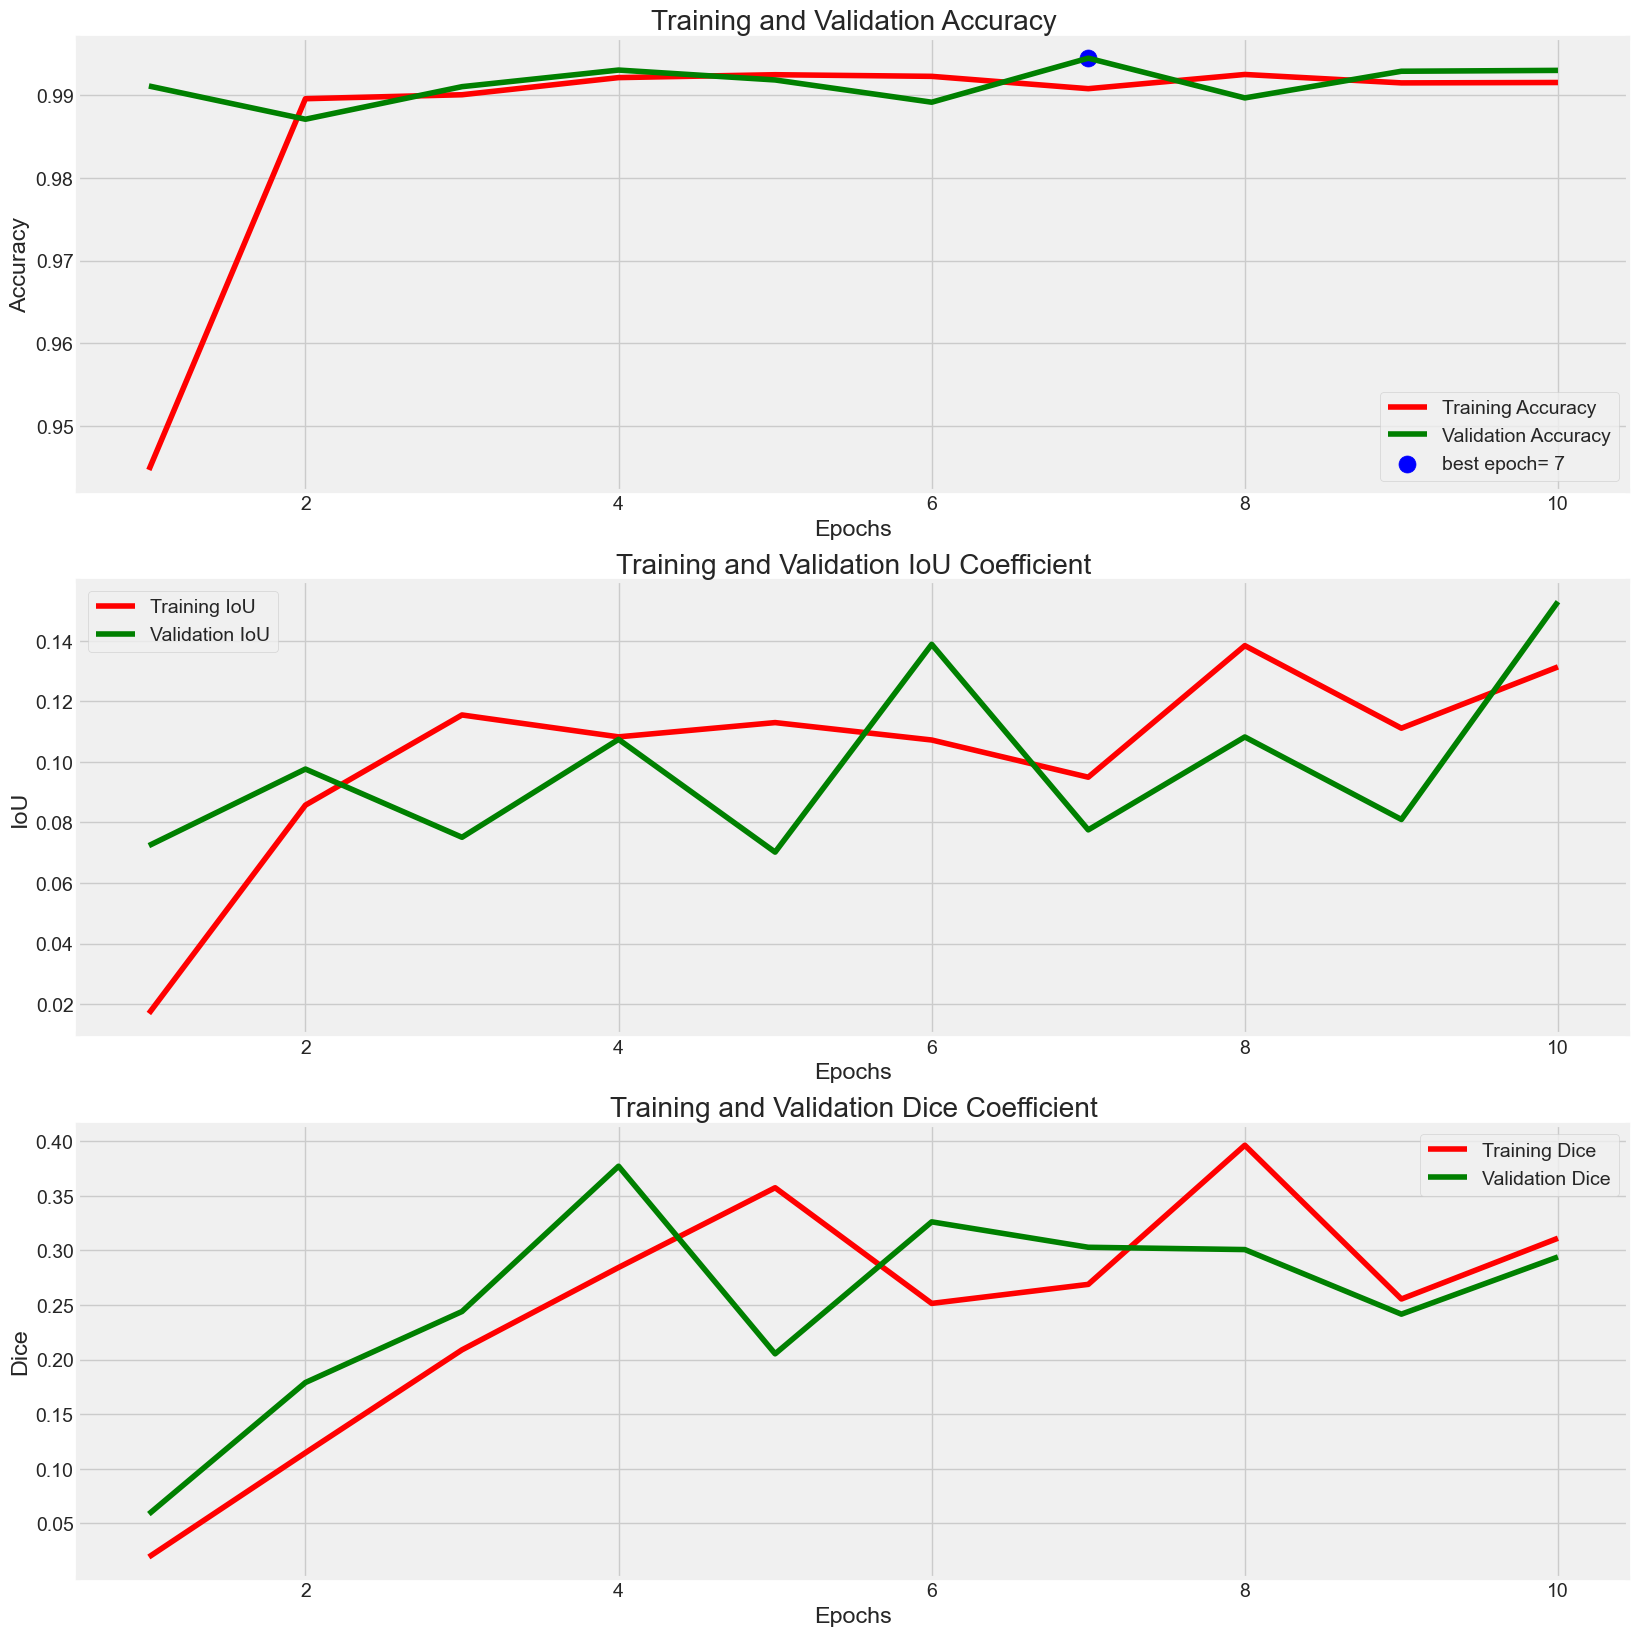

In [14]:
plot_training(history)

In [15]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(val_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)


print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train IoU: ", train_score[2])
print("Train Dice: ", train_score[3])
print('-' * 20)

print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print("Valid IoU: ", valid_score[2])
print("Valid Dice: ", valid_score[3])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test IoU: ", test_score[2])
print("Test Dice: ", test_score[3])

131/131 ━━━━━━━━━━━━━━━━━━━━ 1396s 11s/step - accuracy: 0.9914 - dice_coef: 0.3196 - iou_coef: 0.1210 - loss: 0.0287
131/131 ━━━━━━━━━━━━━━━━━━━━ 1336s 10s/step - accuracy: 0.9912 - dice_coef: 0.3141 - iou_coef: 0.1128 - loss: 0.0283
Found 393 validated image filenames.
Found 393 validated image filenames.
131/131 ━━━━━━━━━━━━━━━━━━━━ 1341s 10s/step - accuracy: 0.9926 - dice_coef: 0.3593 - iou_coef: 0.1232 - loss: 0.0258
Train Loss:  0.02799011953175068
Train Accuracy:  0.9915357828140259
Train IoU:  0.32220858335494995
Train Dice:  0.12227804213762283
--------------------
Valid Loss:  0.028347961604595184
Valid Accuracy:  0.991218626499176
Valid IoU:  0.3204287588596344
Valid Dice:  0.11435488611459732
--------------------
Test Loss:  0.025517811998724937
Test Accuracy:  0.9926661252975464
Test IoU:  0.3638000190258026
Test Dice:  0.12401652336120605


In [16]:
from datetime import datetime
now = datetime.now()
 
print("now =", now)
dt_string = now.strftime("%d.%m..%H.%M")

model_json = model.to_json()
name="C:\\Users\\gotze\\OneDrive\\Desktop\\Parul Hackathon\\segmentation_model"
print(name)
json_file = open(name+".json", "w")

json_file.write(model_json)
json_file.close()

model.save_weights(name+".weights.h5")
print("saving done")

now = 2024-07-18 16:39:54.671315
C:\Users\gotze\OneDrive\Desktop\Parul Hackathon\segmentation_model
saving done


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


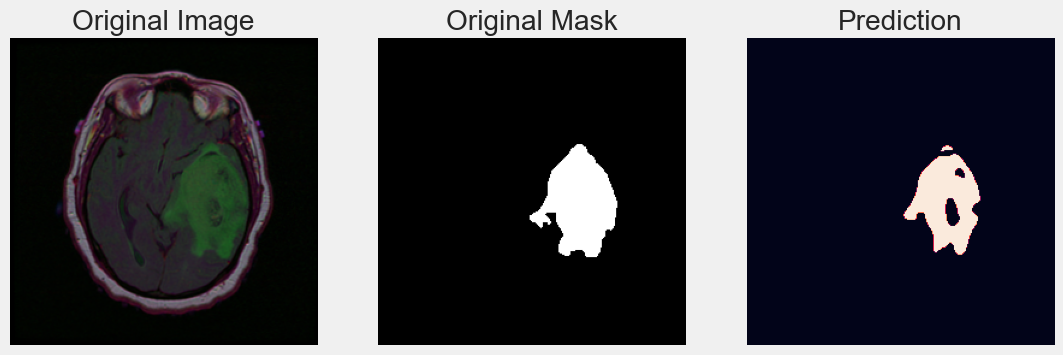

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


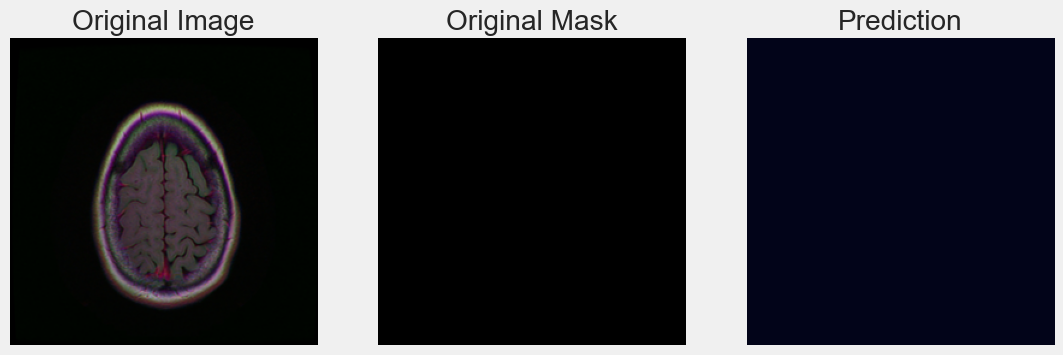

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


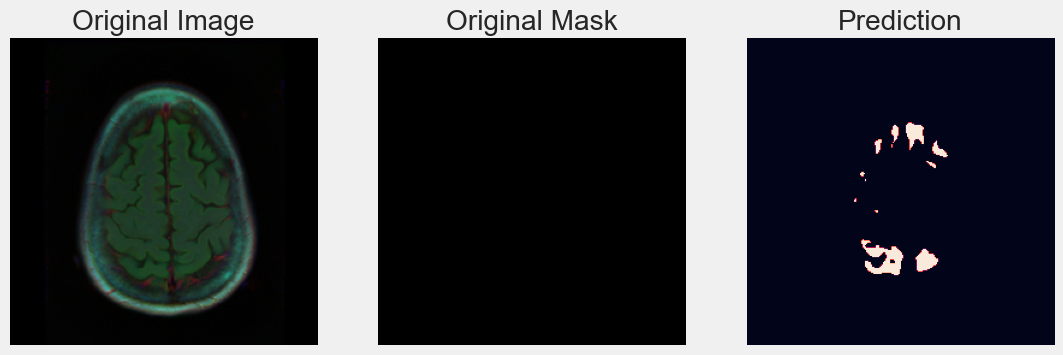

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


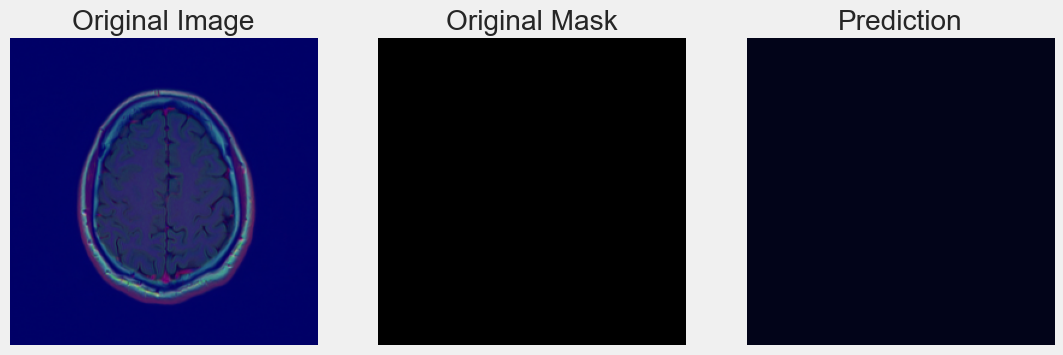

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


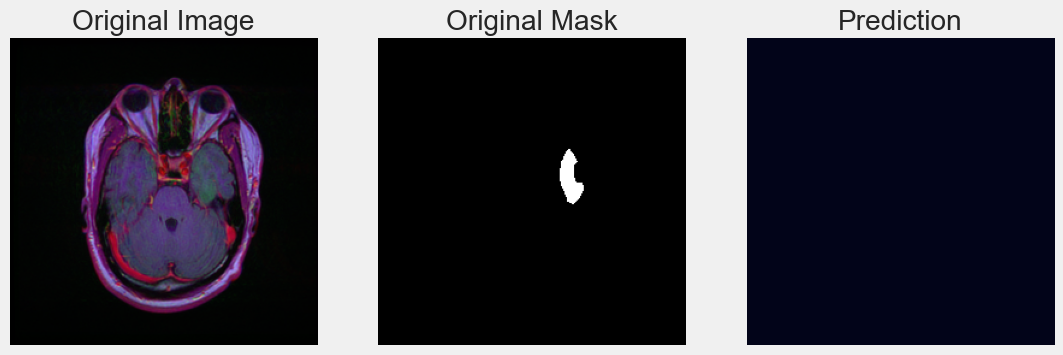

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


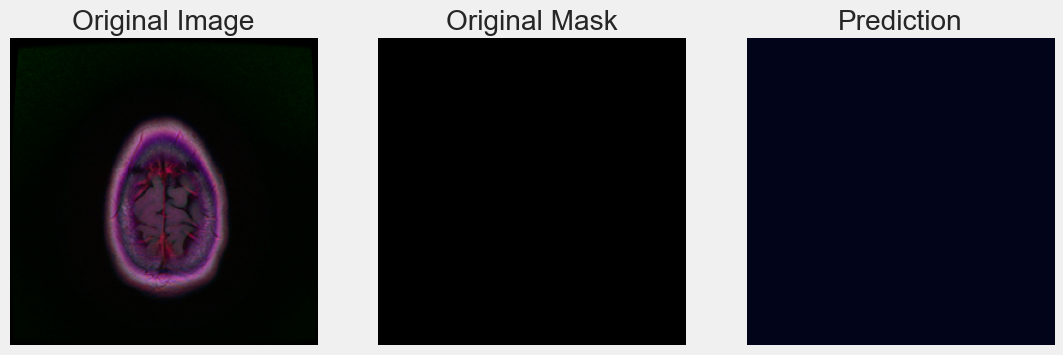

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


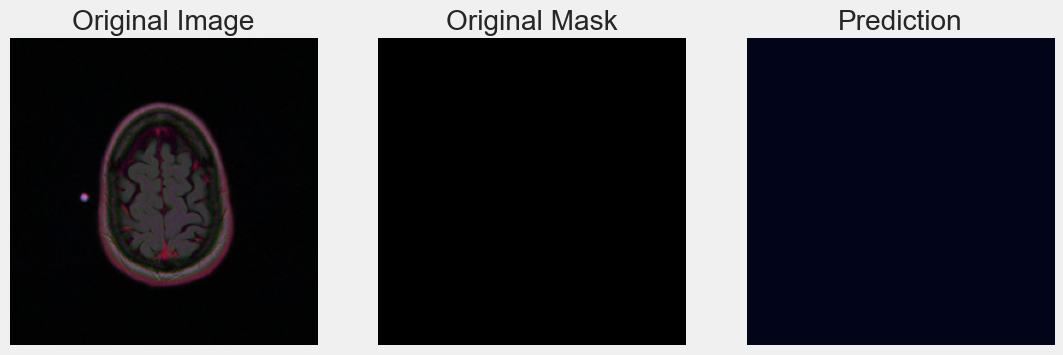

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


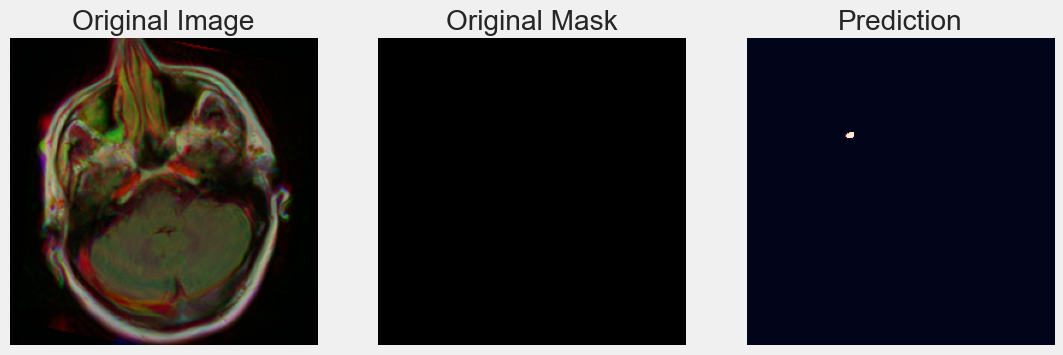

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


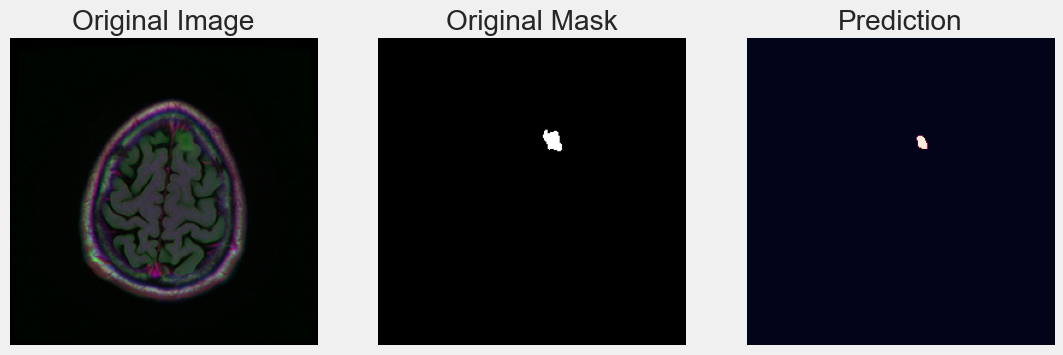

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


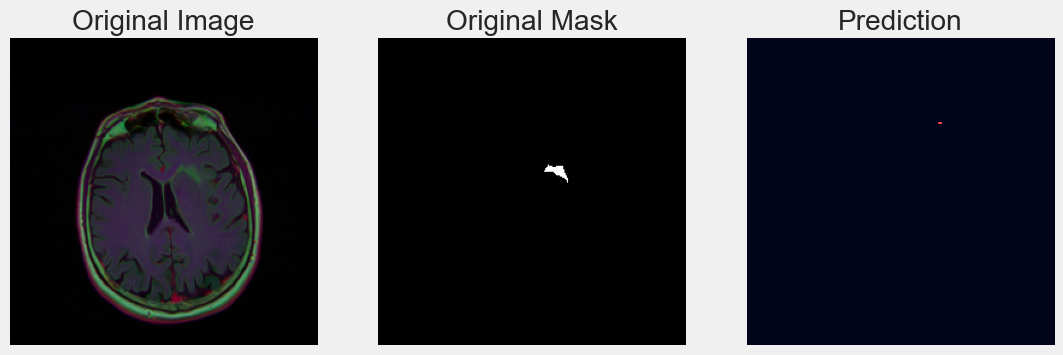

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


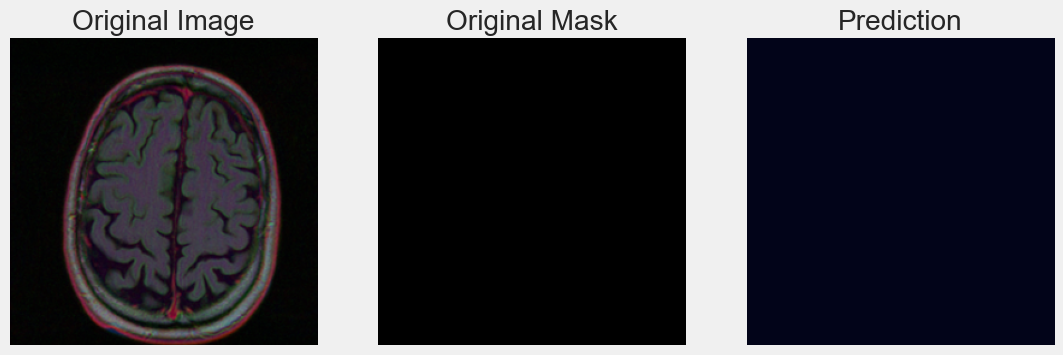

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


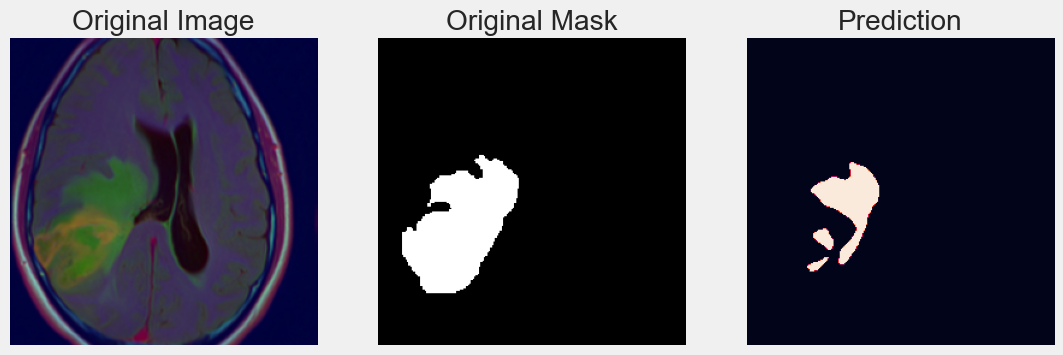

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


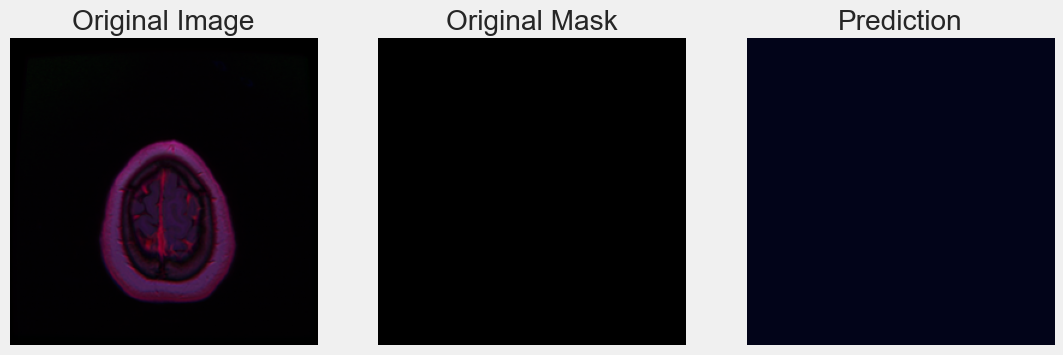

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


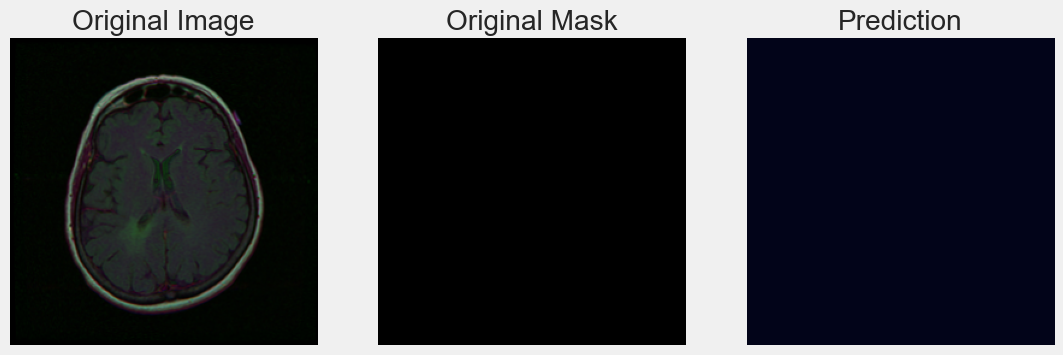

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


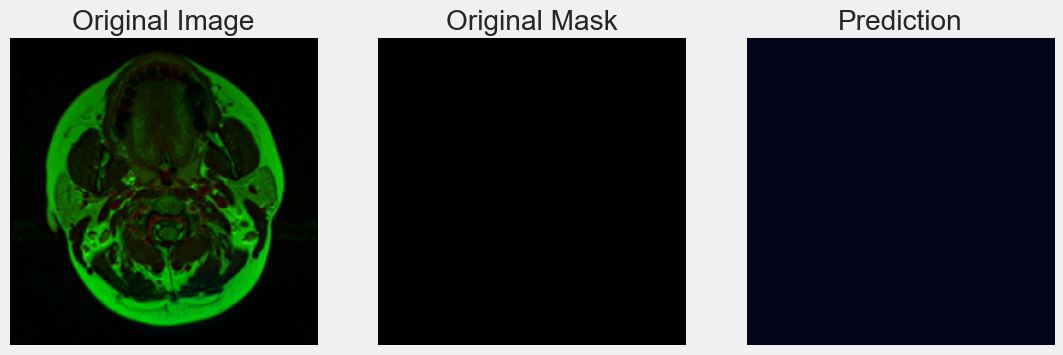

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


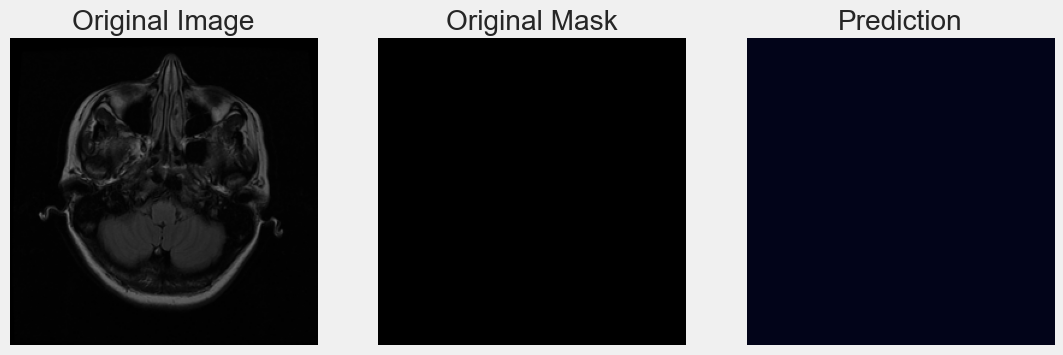

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


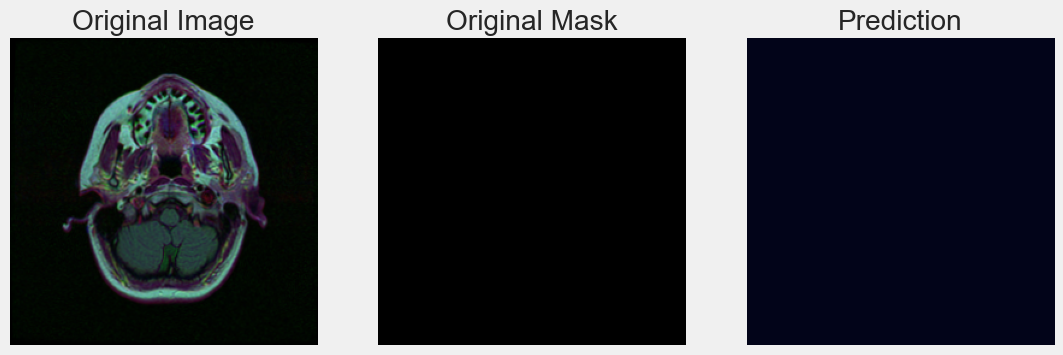

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


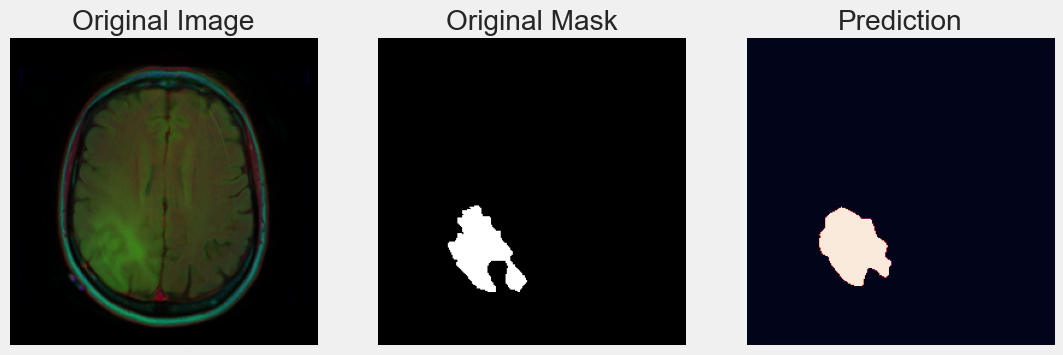

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


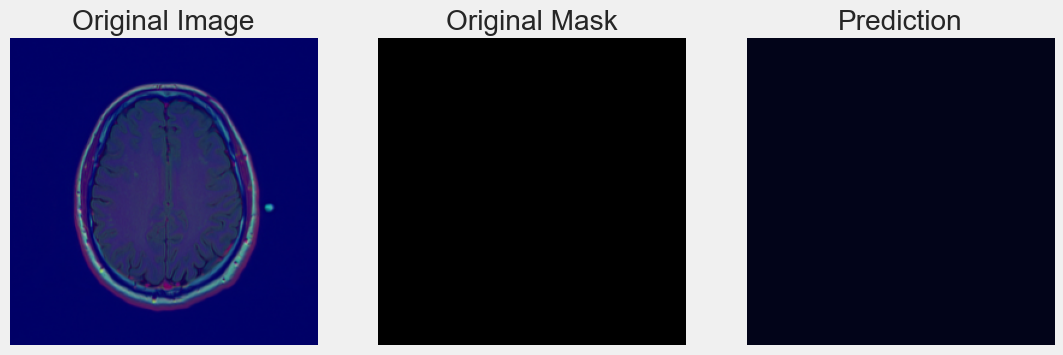

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


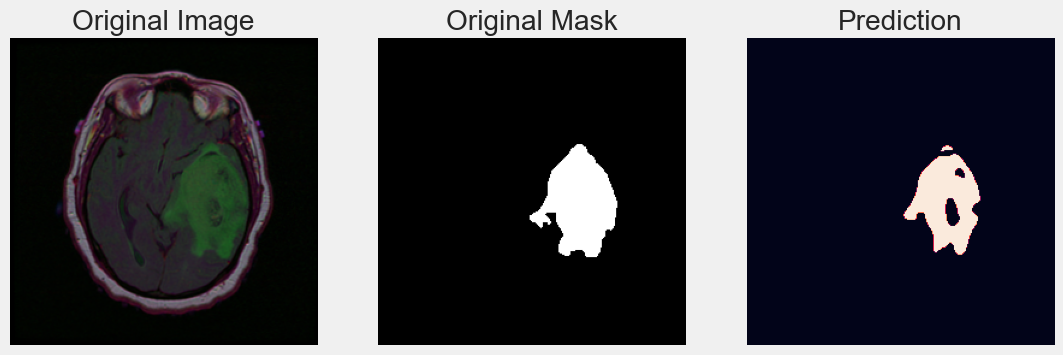

In [17]:
for _ in range(20):
    index = np.random.randint(1, len(test_df.index))
    img = cv2.imread(test_df['images_paths'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = model.predict(img)

    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(test_df['masks_paths'].iloc[index])))
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.axis('off')
    
    plt.show()

In [20]:
from tensorflow.keras.models import model_from_json

# Define the custom function (ensure it matches the one used during model training)
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth=1):
    return 1.0 - dice_coef(y_true, y_pred, smooth)

def iou(y_true, y_pred):#analyze only ones forms. dont calculate zero sections
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    y_true_f = tf.cast(y_true, tf.float32)
    y_pred_f = tf.cast(y_pred, tf.float32)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection#sum areas and sub intersection
    return (intersection + 1e-7) / (union + 1e-7)

def iou_loss(y_true, y_pred):#analyze only ones forms
    #return 1/iou(y_true, y_pred)
    return 1.0 - iou(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth = 1):#analyze only ones forms. dont calculate zero sections
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
# Load the model architecture from JSON file
json_file_path = 'segmentation_best_model_part_2.json'
with open(json_file_path, 'r') as json_file:
    model_json = json_file.read()

# Create the model from the loaded architecture
model = model_from_json(model_json, custom_objects={'dice_coef': dice_coef, 'iou_loss': iou_loss, 'iou_coef': iou_coef})

# Load the weights into the model
weights_file_path = 'segmentation_best_model_part_2.weights.h5'
model.load_weights(weights_file_path)

# Compile the model (use the same optimizer and loss function as you did during training)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dice_coef])

print("Model loaded and compiled successfully.")


Model loaded and compiled successfully.


In [21]:
import math

In [22]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

In [23]:
epochs = 20
new_learning_rate = 0.0001
model.load_weights('C:/Users/gotze/OneDrive/Desktop/Parul Hackathon/segmentation_model.weights.h5')
batch_size = 150

history = model.fit(
    train_gen,
    steps_per_epoch=math.ceil(len(train_df) / batch_size),
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    validation_data=val_gen,
    validation_steps=math.ceil(len(val_df) / batch_size),
    initial_epoch=2
)

c:\Users\gotze\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 98 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 68s/step - accuracy: 0.9884 - dice_coef: 0.1185 - loss: 0.0862  Found 393 validated image filenames.
Found 393 validated image filenames.
21/21 ━━━━━━━━━━━━━━━━━━━━ 1460s 70s/step - accuracy: 0.9884 - dice_coef: 0.1196 - loss: 0.0851 - val_accuracy: 0.9943 - val_dice_coef: 0.1999 - val_loss: 0.0224
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1466s 70s/step - accuracy: 0.9927 - dice_coef: 0.2612 - loss: 0.0269 - val_accuracy: 0.9937 - val_dice_coef: 0.3004 - val_loss: 0.0292
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1471s 70s/step - accuracy: 0.9915 - dice_coef: 0.3099 - loss: 0.0283 - val_accuracy: 0.9940 - val_dice_coef: 0.4015 - val_loss: 0.0219
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1502s 72s/step - accuracy: 0.9926 - dice_coef: 0.3819 - loss: 0.0263 - val_accuracy: 0.9949 - val_dice_coef: 0.4564 - val_loss: 0.0188
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1479s 70s/step - accuracy:

In [21]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(val_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)


print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train IoU: ", train_score[2])
print("Train Dice: ", train_score[3])
print('-' * 20)

print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print("Valid IoU: ", valid_score[2])
print("Valid Dice: ", valid_score[3])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test IoU: ", test_score[2])
print("Test Dice: ", test_score[3])

131/131 [==============================] - 67s 509ms/step - loss: 0.0070 - accuracy: 0.9979 - dice_coef: 0.8734 - iou_coef: 0.8072
Train Loss:  0.002221784321591258
Train Accuracy:  0.999064564704895
Train IoU:  0.933667778968811
Train Dice:  0.8639540076255798
--------------------
Valid Loss:  0.00580726470798254
Valid Accuracy:  0.9983018040657043
Valid IoU:  0.879138171672821
Valid Dice:  0.8196547627449036
--------------------
Test Loss:  0.006951987277716398
Test Accuracy:  0.9979262351989746
Test IoU:  0.8734467029571533
Test Dice:  0.8072022795677185


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


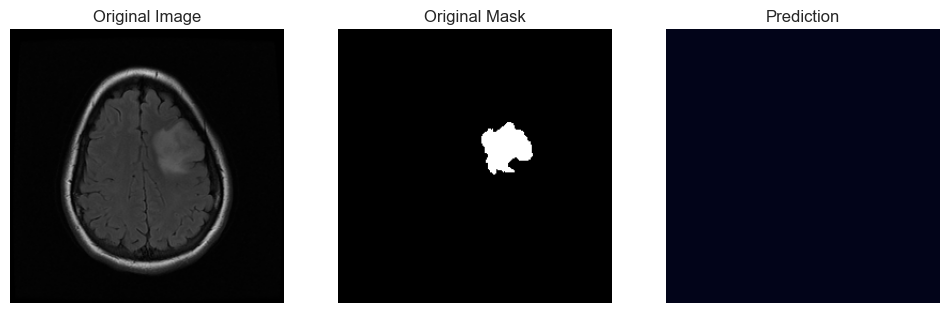

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


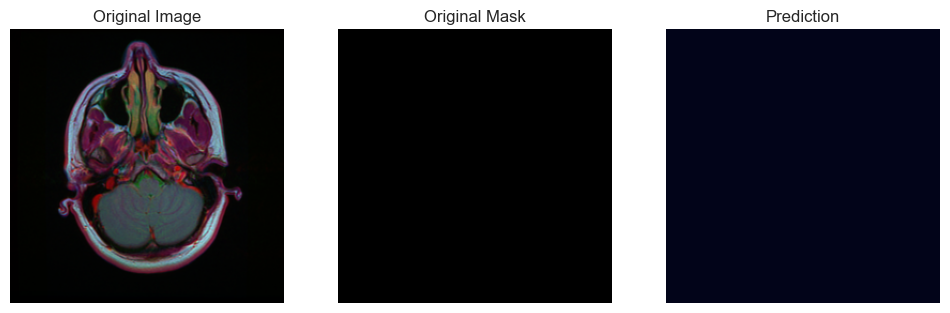

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


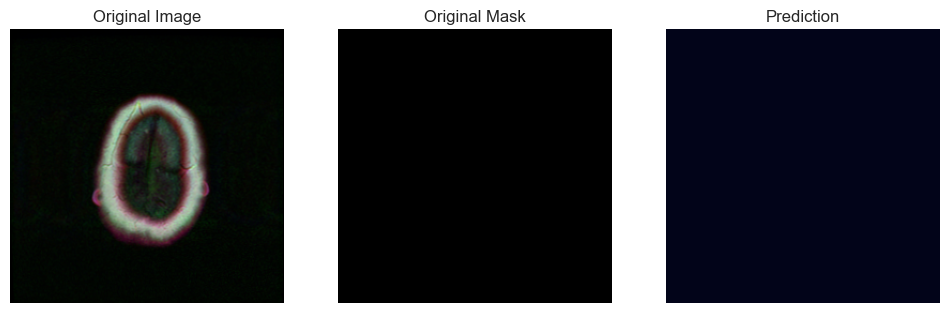

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


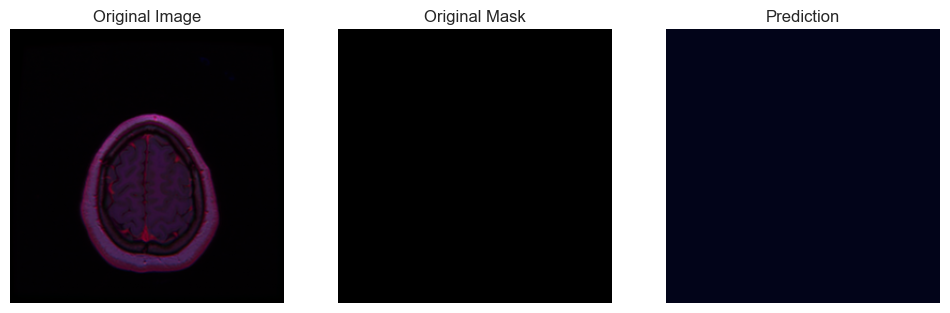

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


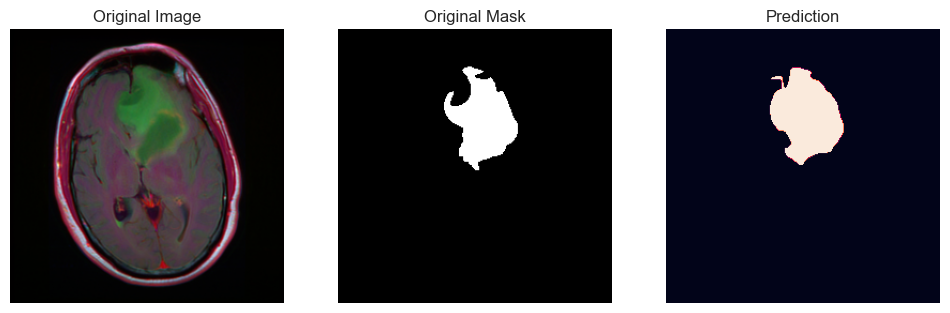

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


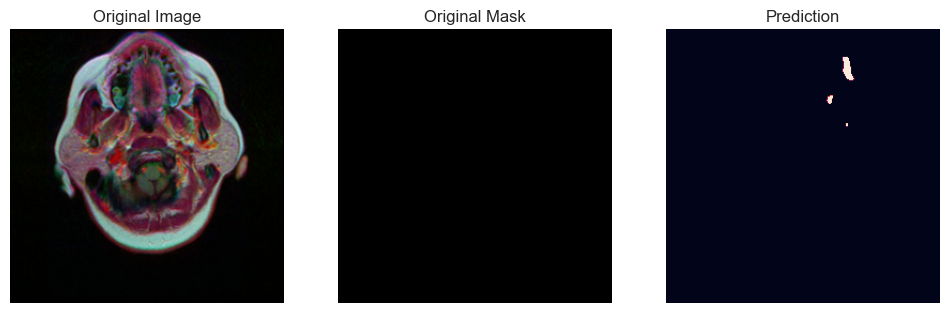

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


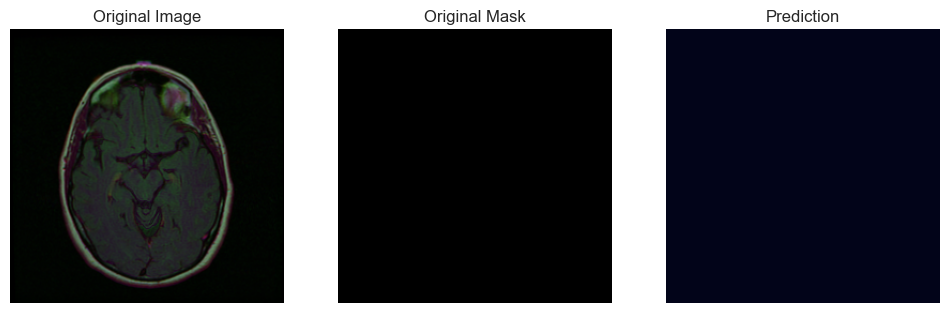

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


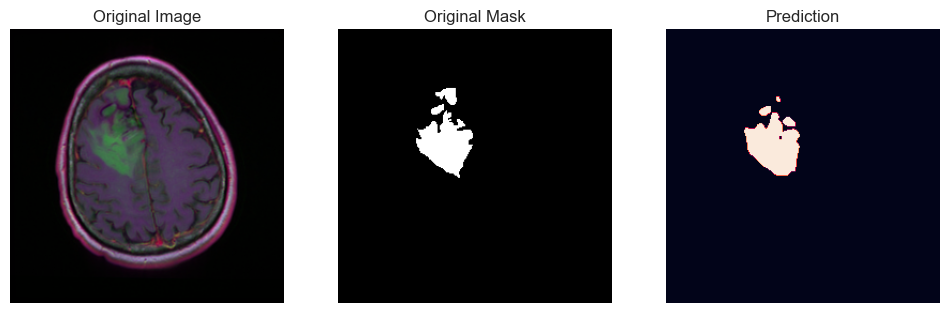

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


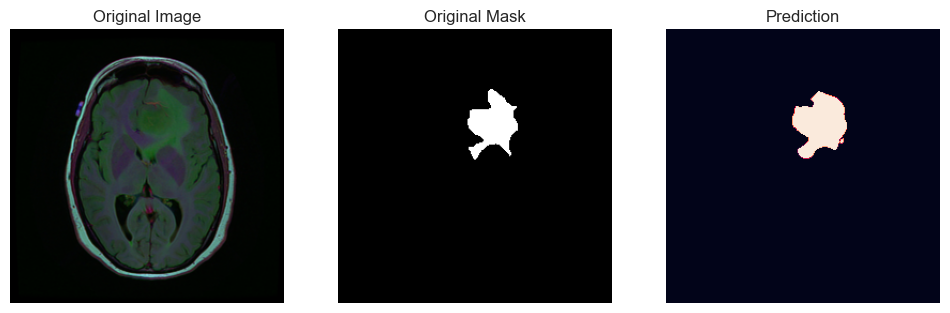

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


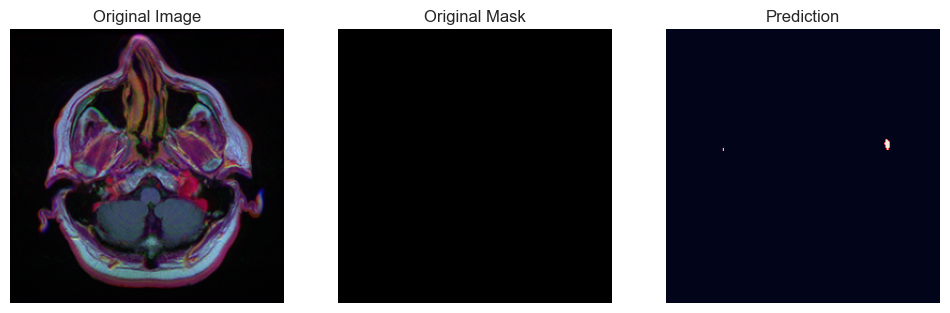

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


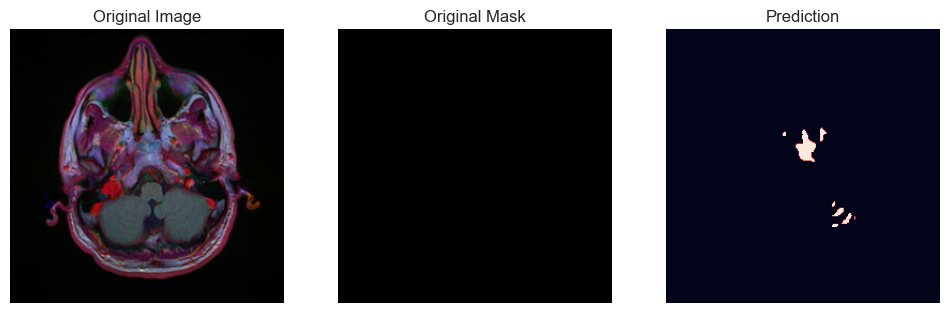

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


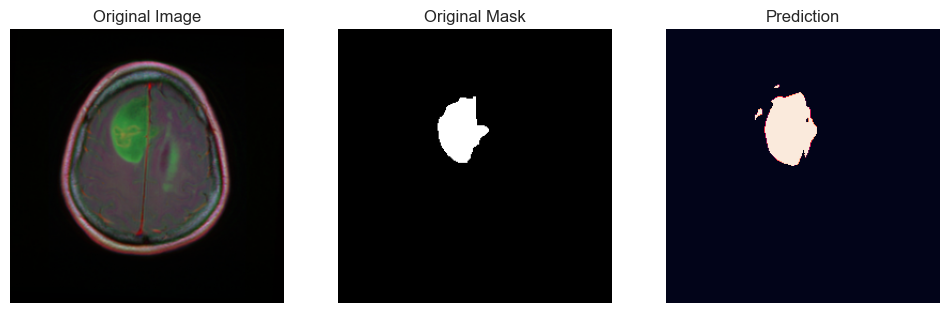

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


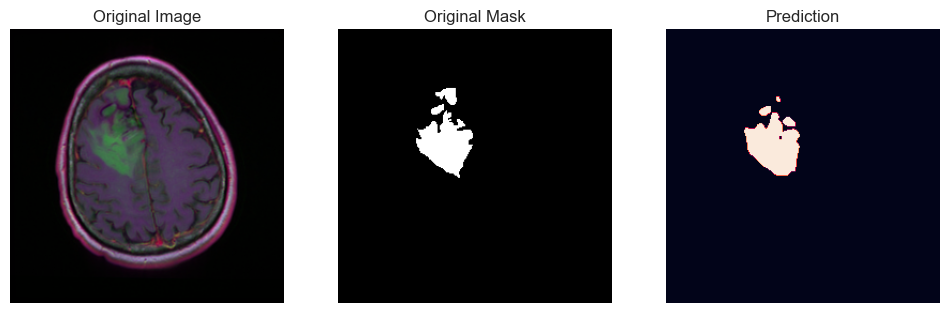

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


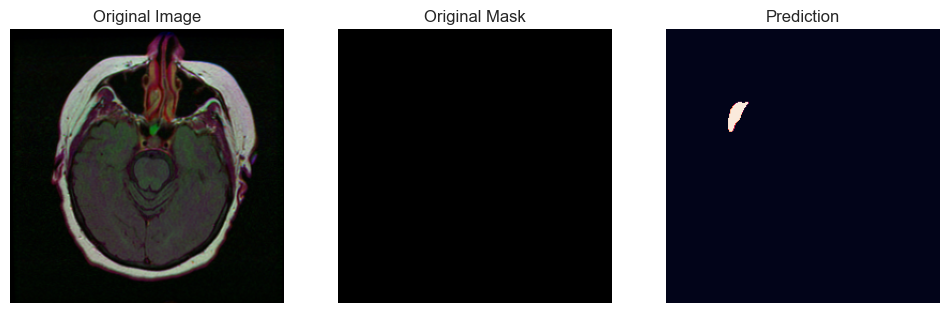

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


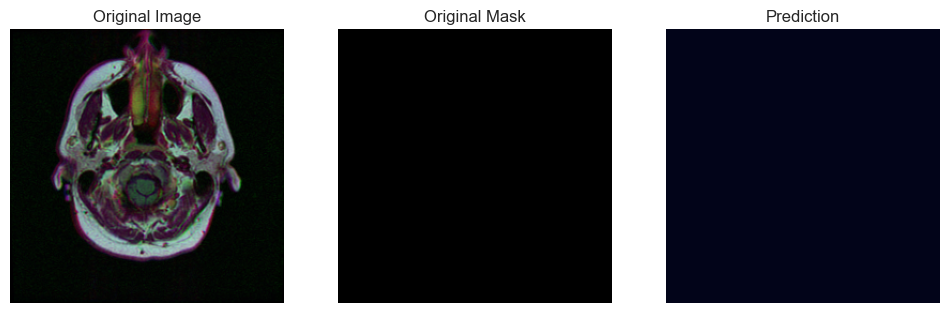

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


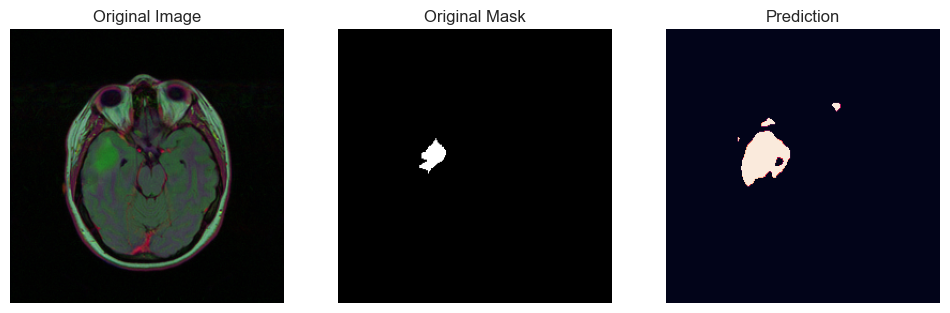

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


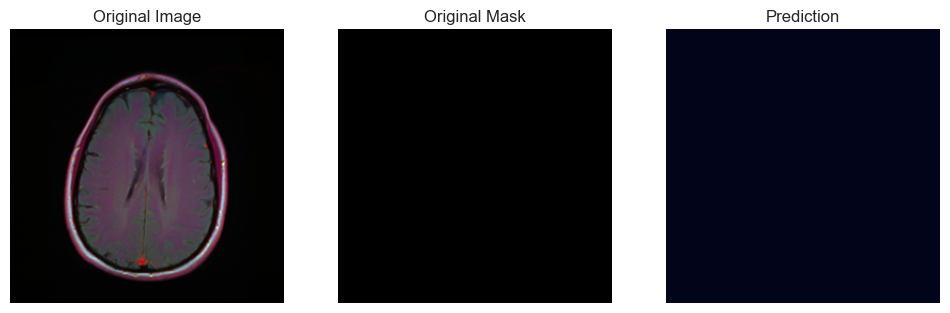

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


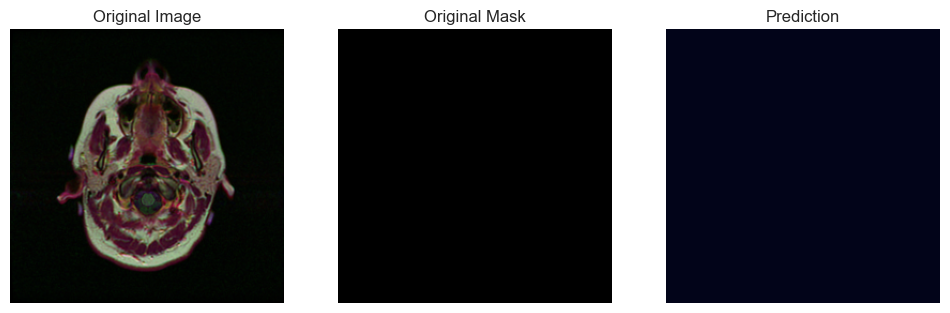

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


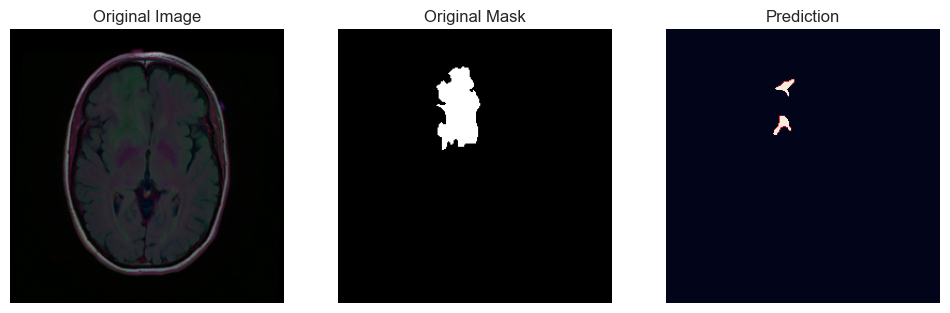

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


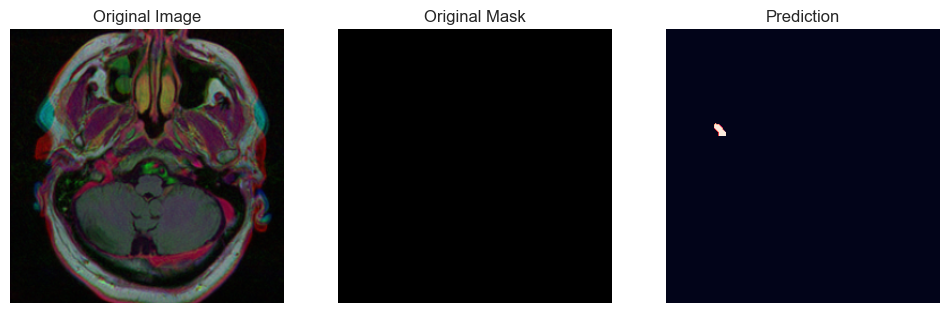

In [26]:
for _ in range(20):
    index = np.random.randint(0, len(test_df.index))
    img = cv2.imread(test_df['images_paths'].iloc[index])
    img = cv2.resize(img, (256, 256))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = model.predict(img)

    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(test_df['masks_paths'].iloc[index])))
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.axis('off')
    
    plt.show()

In [27]:
from datetime import datetime
now = datetime.now()
 
print("now =", now)
dt_string = now.strftime("%d.%m..%H.%M")

model_json = model.to_json()
name="C:\\Users\\gotze\\OneDrive\\Desktop\\Parul Hackathon\\segmentation_best_model_part_3"
print(name)
json_file = open(name+".json", "w")

json_file.write(model_json)
json_file.close()

model.save_weights(name+".weights.h5")
print("saving done")

now = 2024-07-20 01:39:52.366317
C:\Users\gotze\OneDrive\Desktop\Parul Hackathon\segmentation_best_model_part_3
saving done


In [36]:
import numpy as np
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K

# Define the custom dice coefficient function
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Load the model architecture from JSON
with open('segmentation_best_model_part_3.json', 'r') as json_file:
    model_json = json_file.read()
model = model_from_json(model_json, custom_objects={'dice_coef': dice_coef})

# Load the model weights
model.load_weights('segmentation_best_model_part_3.weights.h5')

def preprocess_image(image_path):
    # Load the image with the target size
    img = load_img(image_path, target_size=(256, 256))
    # Convert the image to array
    img_array = img_to_array(img)
    # Normalize the image
    img_array = img_array / 255.0
    # Expand dimensions to match the model input shape
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def postprocess_prediction(prediction):
    # Remove the batch dimension
    prediction = np.squeeze(prediction, axis=0)
    # Apply a threshold to convert to binary image
    prediction = (prediction > 0.5).astype(np.uint8)
    return prediction

def predict_segmentation(image_path):
    # Preprocess the input image
    preprocessed_image = preprocess_image(image_path)
    # Make prediction
    prediction = model.predict(preprocessed_image)
    # Postprocess the prediction
    processed_prediction = postprocess_prediction(prediction)
    return processed_prediction

def display_image(image, title='Image'):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def save_image(image, filepath, title='Image'):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.savefig(filepath)
    plt.close()

# Function to handle file upload and prediction
def predict_and_display(image_path):
    # Make a prediction
    prediction = predict_segmentation(image_path)
    # Display the input image
    input_image = load_img(image_path)
    display_image(input_image, title='Input Image')
    # Display the predicted segmentation
    display_image(prediction, title='Predicted Segmentation')

def predict_and_save(image_path, save_path):
    # Make a prediction
    prediction = predict_segmentation(image_path)
    # Save the predicted segmentation
    save_image(prediction, save_path, title='Predicted Segmentation')

# Example usage:
# predict_and_display('/path/to/your/image.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


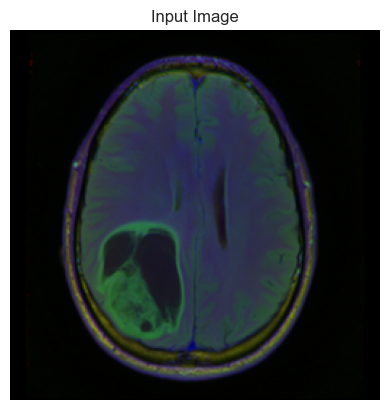

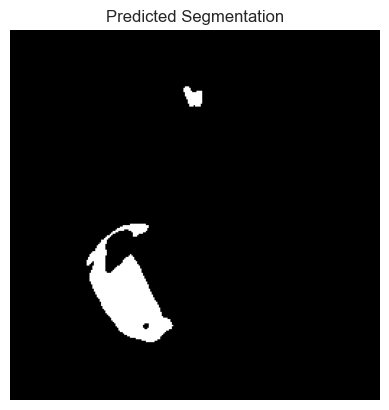

In [32]:
predict_and_display("kaggle_3m\\TCGA_CS_6666_20011109\\TCGA_CS_6666_20011109_19.tif")

In [38]:
predict_and_save("kaggle_3m\\TCGA_CS_6666_20011109\\TCGA_CS_6666_20011109_19.tif", 'C:\\Users\\gotze\\OneDrive\\Desktop\\html\\predict.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


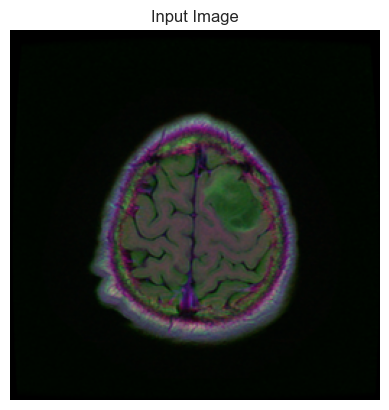

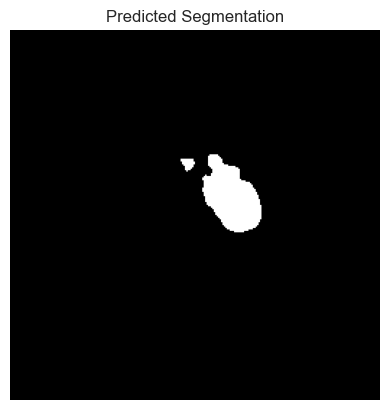

In [33]:
predict_and_display("kaggle_3m\\TCGA_DU_5853_19950823\\TCGA_DU_5853_19950823_30.tif")

In [26]:
epochs = 600
new_learning_rate = 0.00001
model.load_weights('/kaggle/working/segmentation_model.h5')

history = model.fit(
    train_gen,
    steps_per_epoch=len(train_df) / batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
    validation_data=val_gen,
    validation_steps=len(val_df) / batch_size,
    initial_epoch=400
)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/kaggle/working/segmentation_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)